In [2]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
raw = pd.read_excel('E:\\Documents\\WeChat Files\\wxid_7986969869712\\FileStorage\\File\\2023-10\\data2.xlsx', header=None)

In [13]:
raw[0]

0      2137.453000
1      3186.910740
2      3932.432489
3      4422.167493
4      4704.265000
          ...     
664    3433.157000
665    3435.266441
666    3440.475306
667    3449.669268
668    3463.734000
Name: 0, Length: 669, dtype: float64

In [7]:
raw.shape

(669, 13)

In [8]:
data = raw[0]

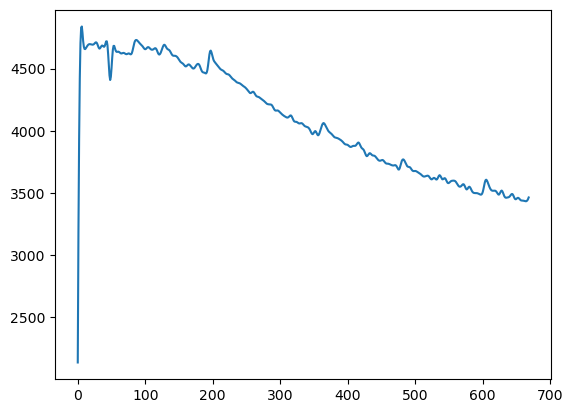

In [9]:
plt.plot(range(len(data)), data)

In [10]:
data = data.reset_index(drop=True)

In [11]:
data

0      2137.453000
1      3186.910740
2      3932.432489
3      4422.167493
4      4704.265000
          ...     
664    3433.157000
665    3435.266441
666    3440.475306
667    3449.669268
668    3463.734000
Name: 0, Length: 669, dtype: float64

In [19]:
def CCMethod(data, max_d):
    """
    该函数用于计算延迟时间tau和时间窗口tw
    data:输入的时间序列-->1维向量
    max_d:最大延迟时间
    """
    N = len(data)  # 168
    S_mean = np.zeros([1, max_d])  # 重构的每个维度的均值初始化
    Sdelta_mean = np.zeros([1, max_d])
    Scor = np.zeros([1, max_d])
    sigma = np.std(data)  # 标准差
    r_division = list(range(1, 5))
    m_list = list(range(2, 6))
    # r的取值是自己定的
    # m-->[2,5]
    # r-->[sigma/2, 2sigma]
    # 将sigma拆分成4等分:[sigma/2,sigma,3sigma/2,2sigma]=sigma/2*[1,2,3,4]

    for t in range(1, max_d+1):  # 1到100
        with tqdm(total=len(m_list), desc='<%d/%d>' % (t, max_d), leave=False) as pbar:
            S = np.zeros([len(m_list), len(r_division)])  # (4,4)
            S_delta = np.zeros([1, len(m_list)])  # (1,4)
            for m in m_list:  # 2到5
                for r_d in r_division:  # 1到4
                    r = sigma/2 * r_d
                    # 分解成t个不相交的时间序列
                    sub_data = subdivide(data, t)  # 对的(int(N/t), t)
                    s = 0
                    Cs1 = np.zeros([t])  # t个
                    # Cs1 = np.zeros([t+1])
                    Cs = np.zeros([t])
                    # Cs = np.zeros([t+1])
                    # 索引为t+1
                    # for tau in range(t):# t=0-->1,t=4-->5
                    for tau in range(1, t+1):  # 1,..,t
                        N_t = N // t
                        # Y = sub_data[:, tau]
                        Y = sub_data[:, tau-1]  # 索引值为tau-1-->(N_t, 1)
                        for i in range(N_t-1):
                            for j in range(i, N_t):
                                d1 = np.abs(Y[i] - Y[j])
                                if r > d1:
                                    # Cs1[tau] += 1
                                    Cs1[tau-1] += 1
                        # Cs1[tau] = 2*Cs1[tau] / (N_t*(N_t-1)) # 延迟为tau的关联积分
                        Cs1[tau-1] = 2 * Cs1[tau-1] / (N_t * (N_t-1))
                        Z = reconstruction(Y, m, 1)  # (m, N_t-(m-1))
                        # 相空间重构
                        M = N_t - (m - 1)
                        # print(M)
                        # 计算C(m, N/t, r, t)
                        # Cs[tau] = correlation_integral(Z, M, r)
                        Cs[tau-1] = correlation_integral(Z, M, r)
                        # 对t个不相关的时间序列求和
                        s += Cs[tau-1] - Cs1[tau-1]**m
                    # 计算每个m和r下的统计量s(m,r,t)
                    # 对应的索引m-2, r_d-1
                    S[m-2, r_d-1] = s/tau
                # 差量计算
                S_delta[0, m-2] = max(S[m-2, :])-min(S[m-2, :])
                pbar.update(1)
        # 计算平均值,索引其实是t-1
        # S_mean[1, t] = np.mean(np.mean(S_delta))
        S_mean[0, t-1] = np.mean(np.mean(S))
        # Sdelta_mean[1, t]=np.mean(S_delta)
        Sdelta_mean[0, t-1] = np.mean(S_delta)
        # Scor[1, t] = abs(S_mean[1, t]+Sdelta_mean[1, t])
        Scor[0, t-1] = np.abs(S_mean[0, t-1]+Sdelta_mean[0, t-1])
    return Sdelta_mean, Scor

# 拆分t个不相交的时间序列


def subdivide(data, t):  # t=t+1
    """
    将长度为n的时间序列拆分成n/t * t的矩阵，
    """
    # t = t+1
    n = len(data)
    Data = np.zeros([int(n/t), t])
    for i in range(t):
        assert t != 0
        for j in range(int(n/t)):
            Data[j, i] = data[i + j * t]
    return Data

# 相空间重构


def reconstruction(data, m, tau):
    """
    该函数用来重构相空间
    m:嵌入维数
    tau：时间延迟
    return:Data-->(m,n)
    """
    n = len(data)
    M = n - (m-1) * tau
    Data = np.zeros([m, M])
    for j in range(M):
        for i in range(m):
            Data[i, j] = data[i*tau+j]
    return Data


def correlation_integral(Z, M, r):
    """
    该函数用来计算关联积分
    return:C_I-->关联积分值
    """
    sum_H = 0
    for i in range(M-1):
        for j in range(i+1, M):
            # 求范数，无穷大
            d = np.linalg.norm(Z[:, i]-Z[:, j], ord=np.inf)
            if r > d:
                sum_H += 1
    C_I = 2*sum_H / (M * (M-1))
    return C_I


def get_tau(Sdelta_mean):  # 有可能是局部最小值,相当于第一次找到
    Sdelta_mean = Sdelta_mean.reshape(-1)
    for i in range(1, len(Sdelta_mean)-1):
        if Sdelta_mean[i] < Sdelta_mean[i-1] and Sdelta_mean[i] < Sdelta_mean[i+1]:
            tau = i
            return tau+1
        else:
            continue


def get_tw(Scor):
    Scor = Scor.reshape(-1)
    return np.argmin(Scor)+1


def get_embedding_m(tau, t_w):
    assert tau != 0
    return int(t_w / tau) + 1


for i in range(len(raw.columns)):
    data = raw[i]
    max_d = 100
    start = time.time()
    Sdelta_mean, Scor = CCMethod(data, max_d)
    print(f"统计量计算用时:{time.time()-start}")
    tau = get_tau(Sdelta_mean)
    t_w = get_tw(Scor)
    m = get_embedding_m(tau, t_w)
    print(f"延迟时间tau:{tau},时间窗口tw:{t_w},嵌入维数m:{m}")

统计量计算用时:64.26799464225769
延迟时间tau:5,时间窗口tw:59,嵌入维数m:12


统计量计算用时:63.01974558830261
延迟时间tau:14,时间窗口tw:74,嵌入维数m:6


统计量计算用时:63.135024070739746
延迟时间tau:6,时间窗口tw:74,嵌入维数m:13


统计量计算用时:63.14297151565552
延迟时间tau:10,时间窗口tw:54,嵌入维数m:6


统计量计算用时:64.13340306282043
延迟时间tau:6,时间窗口tw:39,嵌入维数m:7


统计量计算用时:65.2256247997284
延迟时间tau:4,时间窗口tw:59,嵌入维数m:15


统计量计算用时:63.433521032333374
延迟时间tau:6,时间窗口tw:55,嵌入维数m:10


统计量计算用时:62.53501081466675
延迟时间tau:4,时间窗口tw:54,嵌入维数m:14


统计量计算用时:62.79011869430542
延迟时间tau:6,时间窗口tw:54,嵌入维数m:10


统计量计算用时:62.131911277770996
延迟时间tau:4,时间窗口tw:54,嵌入维数m:14


统计量计算用时:62.68142771720886
延迟时间tau:4,时间窗口tw:6,嵌入维数m:2


统计量计算用时:62.59657669067383
延迟时间tau:8,时间窗口tw:96,嵌入维数m:13


统计量计算用时:63.35727882385254
延迟时间tau:2,时间窗口tw:59,嵌入维数m:30
